In [1]:
%matplotlib inline
# 분석에 필요한 패키지 불러오기
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats import outliers_influence
import itertools
import time
import matplotlib.pyplot as plt

# 데이터 불러오기

In [10]:
# 데이터 불러오기
corolla = pd.read_csv("ToyotaCorolla.csv")
corolla.head(3)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0


In [11]:
# 데이터 관측치 갯수(nCar)와 변수의 수(nVar) 확인
nCar = corolla.shape[0]
nVar = corolla.shape[1]
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1436 nVar: 37


# 데이터 전처리

## 범주형 변수를 이진형 변수로 변환

In [12]:
# 가변수 생성
dummy_p = np.repeat(0,nCar)
dummy_d = np.repeat(0,nCar)
dummy_c = np.repeat(0,nCar)

# 연료타입에 대한 위치 인덱스를 저장  
p_idx = np.array(corolla.Fuel_Type == "Petrol") # gasoline
d_idx = np.array(corolla.Fuel_Type == "Diesel")
c_idx = np.array(corolla.Fuel_Type == "CNG")

# 인덱스 슬라이싱 후 (binary = 1) 대입
dummy_p[p_idx] = 1  # Petrol
dummy_d[d_idx] = 1  # Diesel
dummy_c[c_idx] = 1  # CNG

## 불필요한 변수 제거 및 가변수 추가

In [13]:
# np or dict to DF
Fuel = pd.DataFrame({'Petrol': dummy_p, 'Diesel': dummy_d, 'CNG': dummy_c})

# column slice
corolla_ = corolla.dropna().drop(['Id','Model','Fuel_Type'], axis=1, 
                                 inplace=False)
mlr_data = pd.concat((corolla_, Fuel), 1)

In [14]:
mlr_data.head()

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,...,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
0,13500,23,10,2002,46986,90,1,0,2000,3,...,0,0,0,1,0,0,0,0,1,0
1,13750,23,10,2002,72937,90,1,0,2000,3,...,0,0,0,1,0,0,0,0,1,0
2,13950,24,9,2002,41711,90,1,0,2000,3,...,0,0,0,1,0,0,0,0,1,0
3,14950,26,7,2002,48000,90,0,0,2000,3,...,0,0,0,1,0,0,0,0,1,0
4,13750,30,3,2002,38500,90,0,0,2000,3,...,0,1,0,1,0,0,0,0,1,0


## 설명변수(X), 타켓변수(Y) 분리 및 학습데이터와 평가데이터 

In [24]:
mlr_data.shape

(1436, 37)

In [22]:
# price를 제외한 모든 항목 이름
feature_columns = list(mlr_data.columns.difference(['Price']))

X = mlr_data[feature_columns]
y = mlr_data.Price
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=1) #rand seed

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1005, 36) (431, 36) (1005,) (431,)


# 선형회귀모형 모델링 y = f(x)

In [23]:
# Train the MLR
full_model = sm.OLS(train_y, train_x)
fitted_full_model = full_model.fit()

## 학습에 유의미한 변수확인

In [36]:
fitted_full_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     297.2
Date:                Wed, 06 Sep 2017   Prob (F-statistic):               0.00
Time:                        13:18:40   Log-Likelihood:                -8461.0
No. Observations:                1005   AIC:                         1.699e+04
Df Residuals:                     971   BIC:                         1.716e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ABS               -202.4540    137.381     -1.474      0.141    -472.052      67.144
Age_08_04         -119.6512      4.153    -28.808      0.000    -127.802    -111.501
Airbag_1           126.9969    295.899      0.429      0.668    -453.679     707.673
Airbag_2          -118.6408    141.548     -0.838      0.402    -396.415     159.133
Airco              225.2949     95.485      2.359      0.018      37.915     412.675
Automatic          530.3615    156.958      3.379      0.001     222.347     838.376
Automatic_airco   2340.4302    198.211     11.808      0.000    1951.459    2729.402
BOVAG_Guarantee    439.3210    137.858      3.187      0.001     168.787     709.855
Backseat_Divider   -56.5628    139.908     -0.404      0.686    -331.120     217.994
Boardcomputer     -395.3939    123.287     -3.207      0.001    -637.333    -153.454
CD_Player          188.3535    106.878      1.762      0.078     -21.385     398.092
CNG              -1953.8109    279.928     -6.980      0.000   -2503.145   -1404.477
Central_Lock        31.0129    160.947      0.193      0.847    -284.832     346.857
Cylinders           -0.0273      0.002    -11.292      0.000      -0.032      -0.023
Diesel            1696.6253    319.678      5.307      0.000    1069.286    2323.965
Doors              100.2012     43.590      2.299      0.022      14.660     185.743
Gears              -43.4054    203.815     -0.213      0.831    -443.374     356.563
Guarantee_Period    75.9339     14.803      5.130      0.000      46.884     104.984
HP                  53.5088      5.942      9.005      0.000      41.848      65.170
KM                  -0.0162      0.001    -11.832      0.000      -0.019      -0.014
Met_Color           21.1158     80.463      0.262      0.793    -136.785     179.016
Metallic_Rim       256.9483    102.169      2.515      0.012      56.451     457.446
Mfg_Month          -90.6048     10.989     -8.245      0.000    -112.169     -69.041
Mfg_Year             3.8468      0.892      4.314      0.000       2.097       5.597
Mfr_Guarantee      191.5132     78.667      2.434      0.015      37.136     345.891
Mistlamps            8.5371    114.245      0.075      0.940    -215.658     232.733
Petrol             257.1788    242.729      1.060      0.290    -219.155     733.513
Power_Steering    -330.0358    335.284     -0.984      0.325    -988.000     327.929
Powered_Windows    346.9541    160.822      2.157      0.031      31.355     662.553
Quarterly_Tax       14.8799      1.929      7.713      0.000      11.094      18.666
Radio             -465.0620    816.893     -0.569      0.569   -2068.142    1138.018
Radio_cassette     442.7284    819.165      0.540      0.589   -1164.809    2050.266
Sport_Model        370.3652     92.700      3.995      0.000     188.450     552.280
Tow_Bar           -117.

## 그래프로 모델링 적합성 확인

### 정규분포 확인

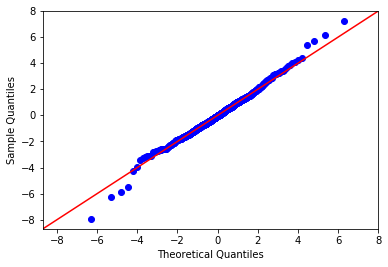

In [29]:
# 학습데이터의 잔차 확인
pred_y = fitted_full_model.predict(train_x)
res = fitted_full_model.resid  # residual

# q-q plot # 정규분포 확인
fig = sm.qqplot(res, stats.t, fit=True, line='45')

### 이상관측치탐색

* Residuals: Y에서 벗어나는 정도
* Leverage: X에서 벗어나는 정도 

In [36]:
sm.graphics.influence_plot?

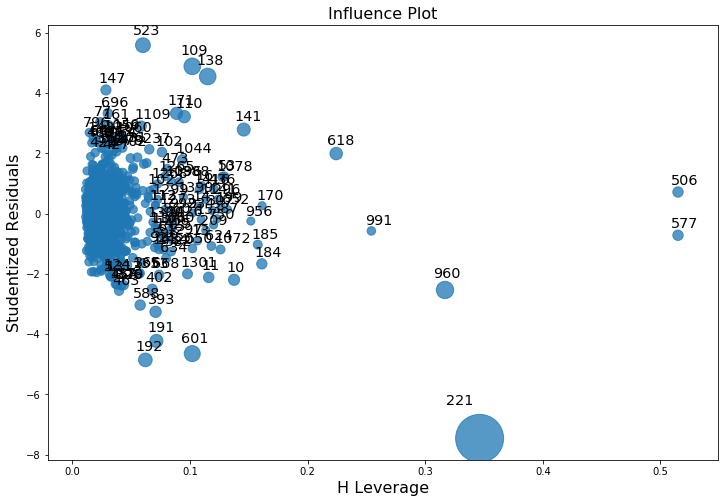

In [26]:
# Cook's distance with high leverage
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(fitted_full_model, ax=ax, 
                                 criterion="cooks", s=2)

In [40]:
sm.graphics.influence_plot?

### 잔차패턴확인

In [31]:
plt.scatter?

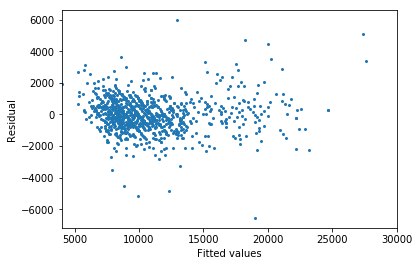

In [39]:
# residual pattern 확인
fig = plt.scatter(pred_y, res, s=4)
plt.xlim(4000,30000)
plt.xlabel('Fitted values')
plt.ylabel('Residual')

# 변수선택법

## processSubset: 해당 feature_set에 대한 모델생성 및 AIC 계산

In [60]:
def processSubset(X,y, feature_set):
            model = sm.OLS(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}
        
print(processSubset(X=train_x, y=train_y, 
                    feature_set = feature_columns[0:5]))

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x115272438>, 'AIC': 19087.157001523432}


## getBest(TrainingSet, Target, 조합 변수의 수)

In [62]:
def getBest(X,y,k):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(X.columns, k): # 각 변수조합을 고려한 경우의 수
        results.append(processSubset(X,y,feature_set=combo))  # 모델링된 것들을 저장
    
    models = pd.DataFrame(results) # 데이터 프레임으로 변환
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time() # 종료시간
    print("Processed ", models.shape[0], 
          "models on", k, 
          "predictors in", round((toc-tic), 4), "seconds.")
    return best_model

print(getBest(X=train_x, y=train_y,k=2))

Processed  630 models on 2 predictors in 0.9652 seconds.
AIC                                                17749.5
model    <statsmodels.regression.linear_model.Regressio...
Name: 67, dtype: object


## 변수조합에 따른 모델링 시간

In [63]:
# 변수 선택에 따른 학습시간과 저장
models = pd.DataFrame(columns=["AIC", "model"])

tic = time.time()
for i in range(1,4):
    models.loc[i] = getBest(X=train_x, y=train_y, k=i)
toc = time.time()

print("Total elapsed time:", round((toc-tic), 4), "seconds.")

Processed  36 models on 1 predictors in 0.0863 seconds.
Processed  630 models on 2 predictors in 1.0633 seconds.
Processed  7140 models on 3 predictors in 10.6383 seconds.
Total elapsed time: 11.8031 seconds.


In [64]:
models

,AIC,model
1,19181.920243,<statsmodels.regression.linear_model.Regressio...
2,17749.459401,<statsmodels.regression.linear_model.Regressio...
3,17513.372800,<statsmodels.regression.linear_model.Regressio...


## 모델평가 지표

In [65]:
models.loc[3, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.968e+04
Date:                Tue, 31 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:50:41   Log-Likelihood:                -8753.7
No. Observations:                1005   AIC:                         1.751e+04
Df Residuals:                    1002   BIC:                         1.753e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age_08_04   -122.0081      2.720    -44.849      0.000    -127.347    -116.670
KM            -0.0240      0.001    -16.366      0.000      -0.027      -0.021
Weight        17.8840      0.127    140.733      0.000      17.635      18.133
==============================================================================
Omnibus:                      147.992   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1509.008
Skew:                          -0.285   Prob(JB):                         0.00
Kurtosis:                       8.976   Cond. No.                     4.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
# 모든 변수들 모델링 한것보다 나은 결과를 가져옴
print("selected model Rsquared: ","{:.5f}".format(models.loc[3, "model"].rsquared))
print("selected model AIC: ","{:.5f}".format(models.loc[3, "model"].aic))
print("selected model MSE: ","{:.5f}".format(models.loc[3, "model"].mse_total))

selected model Rsquared:  0.98331
selected model AIC:  17513.37280
selected model MSE:  129014650.45174


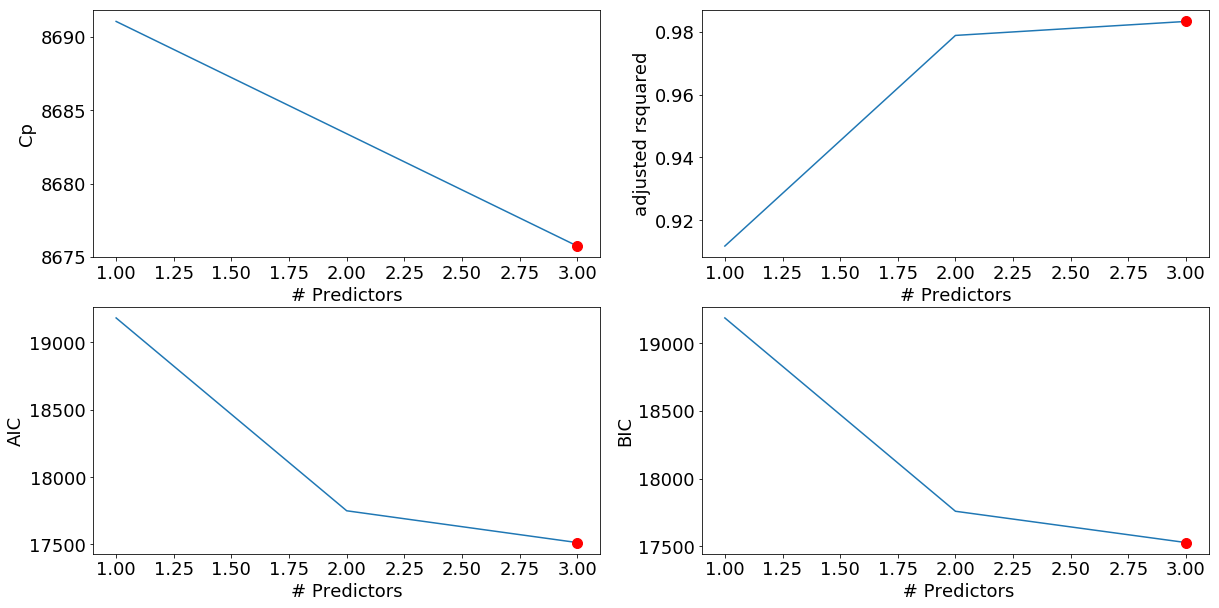

In [67]:
# Plot the result
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

## Mallow Cp
plt.subplot(2, 2, 1)
Cp= models.apply(lambda row: (row[1].params.shape[0]+(row[1].mse_total-
                               fitted_full_model.mse_total)*(train_x.shape[0]-
                                row[1].params.shape[0])/fitted_full_model.mse_total
                               ), axis=1)
plt.plot(Cp)
plt.plot(Cp.argmin(), Cp.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Cp')

# adj-rsquared plot
# adj-rsquared = Explained variation / Total variation
adj_rsquared = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(adj_rsquared)
plt.plot(adj_rsquared.argmax(), adj_rsquared.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# aic
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

# bic
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel(' # Predictors')
plt.ylabel('BIC')

## 전진선택법

### forward: 전진선택법 (step=1)

In [72]:
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors+[p]))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, 
          "predictors in", round((toc-tic), 4))
    print('Selected predictors:',best_model['model'].model.exog_names,
          ' AIC:', round(best_model[0], 4) )
    
    return best_model

### forward_model: 전진선택법 모델

In [73]:
def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
    toc = time.time()
    
    print("Total elapsed time:", round((toc-tic), 4), "seconds.")
    return(Fmodels['model'][len(Fmodels['model'])])

In [74]:
Forward_best_model = forward_model(X=train_x, y= train_y)

Processed  36 models on 1 predictors in 0.0862
Selected predictors: ['Weight']  AIC: 19181.9202
Processed  35 models on 2 predictors in 0.1011
Selected predictors: ['Weight', 'Age_08_04']  AIC: 17749.4594
Processed  34 models on 3 predictors in 0.0747
Selected predictors: ['Weight', 'Age_08_04', 'KM']  AIC: 17513.3728
Processed  33 models on 4 predictors in 0.0664
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco']  AIC: 17326.819
Processed  32 models on 5 predictors in 0.0551
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco', 'HP']  AIC: 17238.1623
Processed  31 models on 6 predictors in 0.0565
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco', 'HP', 'Mfg_Month']  AIC: 17189.687
Processed  30 models on 7 predictors in 0.0595
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco', 'HP', 'Mfg_Month', 'Powered_Windows']  AIC: 17164.5441
Processed  29 models on 8 predictors in 0.0711
Selected predictors: ['Weight', 'Age

In [75]:
Forward_best_model.aic

16972.719613484111

## 후진소거법

### backward: 후진소거법(step=1)

In [76]:
def backward(X,y,predictors):
    tic = time.time()
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y=y,feature_set=combo))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          round((toc - tic), 4) )
    print('Selected predictors:',best_model['model'].model.exog_names,
          ' AIC:', round(best_model[0], 4) )
    return best_model

### backward: 후진소거법모델

In [77]:
def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
    toc = time.time()
    print("Total elapsed time:", round((toc - tic), 4), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])

In [78]:
Backward_best_model = backward_model(X=train_x, y=train_y)

Processed  36 models on 35 predictors in 0.3865
Selected predictors: ['ABS', 'Age_08_04', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic', 'Automatic_airco', 'BOVAG_Guarantee', 'Backseat_Divider', 'Boardcomputer', 'CD_Player', 'CNG', 'Central_Lock', 'Cylinders', 'Diesel', 'Doors', 'Gears', 'Guarantee_Period', 'HP', 'KM', 'Met_Color', 'Metallic_Rim', 'Mfg_Month', 'Mfg_Year', 'Mfr_Guarantee', 'Petrol', 'Power_Steering', 'Powered_Windows', 'Quarterly_Tax', 'Radio', 'Radio_cassette', 'Sport_Model', 'Tow_Bar', 'Weight', 'cc']  AIC: 16987.9164
Processed  35 models on 34 predictors in 0.3295
Selected predictors: ['ABS', 'Age_08_04', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic', 'Automatic_airco', 'BOVAG_Guarantee', 'Backseat_Divider', 'Boardcomputer', 'CD_Player', 'CNG', 'Cylinders', 'Diesel', 'Doors', 'Gears', 'Guarantee_Period', 'HP', 'KM', 'Met_Color', 'Metallic_Rim', 'Mfg_Month', 'Mfg_Year', 'Mfr_Guarantee', 'Petrol', 'Power_Steering', 'Powered_Windows', 'Quarterly_Tax', 'Radio', 'Radio_cass

In [79]:
Backward_best_model.aic

16972.71961348406

## 단계적 선택법

### stepwise_model: 단계적 선택법 모델

In [80]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        if i > 1:
            if Forward_result['AIC'] < before:
                Backward_result = backward(X=X, y=y, predictors=predictors)
                if Backward_result['AIC']< Forward_result['AIC']:
                    Stepmodels.loc[i] = Backward_result
                    predictors = Stepmodels.loc[i]["model"].model.exog_names
                    before = Stepmodels.loc[i]["AIC"]
            else: break
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        before = Stepmodels.loc[i]["AIC"]


    toc = time.time()
    print("Total elapsed time:", round((toc - tic), 4), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [81]:
Stepwise_best_model=Stepwise_model(X=train_x,y=train_y)

Processed  36 models on 1 predictors in 0.074
Selected predictors: ['Weight']  AIC: 19181.9202
Processed  35 models on 2 predictors in 0.0646
Selected predictors: ['Weight', 'Age_08_04']  AIC: 17749.4594
Processed  2 models on 1 predictors in 0.0044
Selected predictors: ['Weight']  AIC: 19181.9202
Processed  34 models on 3 predictors in 0.0517
Selected predictors: ['Weight', 'Age_08_04', 'KM']  AIC: 17513.3728
Processed  3 models on 2 predictors in 0.0046
Selected predictors: ['Weight', 'Age_08_04']  AIC: 17749.4594
Processed  33 models on 4 predictors in 0.0541
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco']  AIC: 17326.819
Processed  4 models on 3 predictors in 0.0063
Selected predictors: ['Weight', 'Age_08_04', 'KM']  AIC: 17513.3728
Processed  32 models on 5 predictors in 0.0649
Selected predictors: ['Weight', 'Age_08_04', 'KM', 'Automatic_airco', 'HP']  AIC: 17238.1623
Processed  5 models on 4 predictors in 0.0112
Selected predictors: ['Weight', 'Age_08_04', 

In [82]:
Stepwise_best_model.aic

16972.719613484111

# 성능평가

In [83]:
# the number of params
print(Forward_best_model.params.shape, 
      Backward_best_model.params.shape, 
      Stepwise_best_model.params.shape)

(25,) (23,) (24,)


In [84]:
# 모델에 의해 예측된/추정된 값 <->  test_y
pred_y_full = fitted_full_model.predict(test_x)
pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [85]:
perf_mat = pd.DataFrame(columns=["ALL", "FORWARD", "BACKWARD", "STEPWISE"],
                        index =['MSE', 'RMSE','MAE', 'MAPE'])

In [86]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
# 성능지표
perf_mat.loc['MSE']['ALL'] = metrics.mean_squared_error(test_y,pred_y_full)
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = metrics.mean_squared_error(test_y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)

perf_mat.loc['RMSE']['ALL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_full))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))

perf_mat.loc['MAE']['ALL'] = metrics.mean_absolute_error(test_y, pred_y_full)
perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = metrics.mean_absolute_error(test_y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)

perf_mat.loc['MAPE']['ALL'] = mean_absolute_percentage_error(test_y, pred_y_full)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(test_y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(test_y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(test_y, pred_y_stepwise)

print(perf_mat)

              ALL      FORWARD     BACKWARD     STEPWISE
MSE   7.56418e+06  7.90926e+06  7.90926e+06  7.90926e+06
RMSE      2750.31      2812.34      2812.34      2812.34
MAE       923.469      929.928      929.928      929.928
MAPE       8.7147      8.76357      8.76357      8.76357
